# Neural Network with PyTorch - MNIST Dataset - Greyscale Handwritten Digits

Here we'll use the MNIST dataset whcich conssist of grescale handwritten digits. each image is a 28X28 pixels. see Sample below:

<img src='assets/mnist.png'>
    
our goal is to buid a neural network that can take one if these images and predict the digit in the image.
The MNIST data set is provided through the `touchvision` pacakage. Below, we download the MNIST dataset and create training and test datasets.

In [14]:
##Import necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
import helper
import matplotlib.pyplot as plt

In [22]:
###Download Data sets
from torchvision import datasets, transforms

#Define transsforms to normalise the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

#Download ans load the training data
trainset = datasets.MNIST('~./pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In the code above, we have the training data loaded into the trainloader and we can make that an iterator with iter(trainloader). Later we'll use this to loop through the dataset for training.

In the trainloader, we uses a batch size of 64 and `shuffle=True`. The batch size is the number of images we can get in onw iteration from the data loader and pass through our network, often called a *batch*. And `shuffle=True` tells it to shuffle the dataset everytime we start going through the dataloader again.

Let's take a look and sample the first batch of imagea and labels below:

In [25]:
#convert to iter
dataiter = iter(trainloader)

#Get the next batch of 64 images and labels
images, labels = dataiter.next() 
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


We can see above that images is just a tensor with size `(64,1,28,28)`. So 64 images per batch, 1 color channel and 28X28 pixels.

This is what one of the images looks like:

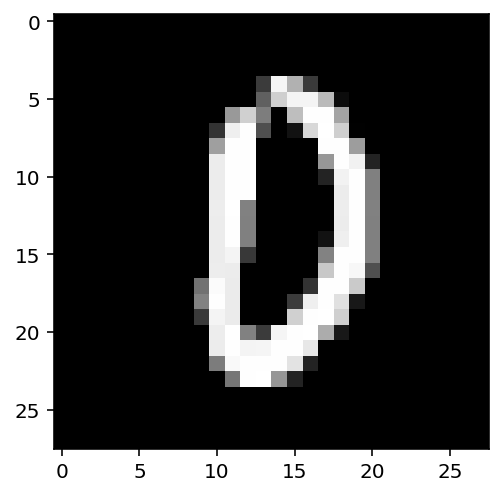

In [28]:
plt.imshow(images[1].numpy().squeeze(),cmap='Greys_r')

We are going to divide our goal into three stages:

1. Build a simple network for this dataset using weight matrices and matrix multiplications
2. Then we see how to build the same using Pytorch's `nn` modules
3. We build the same network using Pytorch's `nn` modules, this time, we use `nn.Sequential()` - a short form way of building neural network.

# Backgorund

We wish to build a fully connected or dense network. In a fully connected or dense network, each unit on one layer is connected to each unit in the next layer. In fully connected networks, the input to each layer must be a one-dimensional vector (1D vector) (which can be stacked into a a 2D tensor as a batch of multiple examples). Hoever, our images are 28X28 2D tensors, so we need to convert them to 1D vectors i.e `(64,1,28,28)` to `(64,784)`. 784 is 28X28. This is typically called `flattening`, we have flattened the 2D images into 1D vectors.

How about the output, we need 10 outputs, one for each 0..9. We want out network to predict the digit shown in an image, so what we'll do is calculate the probability that the image is of any one digit or class. This ends up being a ddscrete probabiity distribution over the classes (digits) that tells us the most likely class for the image. That mesans we need 10 output units for the 10 classes (digits)

# Using Weight Matrices and Matrix Multiplcation

Here we flatten the batch of 64 images, build a mult-layer network with 784 input units, 256 hideen units and and 10 output units unsing weight matrices and matric multiplcation.

In [41]:
#activation function
def activation(x):
    return 1/(1 + torch.exp(-x))

#softmax for the output
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x),dim=1).view(-1,1)

#flattern the images
inputs = images.view(images.shape[0], -1)
print(inputs.shape)

#create parameters
w1 = torch.randn(784,256)
b1 = torch.randn(256)

w2 = torch.randn(256,10)
b2 = torch.randn(10)

#first layer
h = activation(torch.mm(inputs,w1) + b1)

out = torch.mm(h,w2) + b2 # this shuld be shape of (64,10)

print(out)

probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)

# Does it sum to 1?
print(probabilities.sum(dim=1))

torch.Size([64, 784])
tensor([[-6.1440e-01,  5.0046e+00, -2.4256e+00,  7.5987e+00,  1.1397e+01,
          3.3766e+00, -7.4255e+00, -7.6961e-01, -1.1467e+01,  1.0971e+01],
        [ 1.5923e+00,  6.6179e+00, -7.0549e+00,  9.3295e-01,  8.6228e+00,
          8.7348e+00,  8.2324e+00,  5.9724e+00, -6.0282e+00,  7.1078e+00],
        [ 7.7786e+00,  1.1765e+01,  4.4041e+00,  1.4837e+00,  4.9076e+00,
          1.9651e+01,  8.0371e+00,  7.2476e+00, -8.7622e+00,  1.6338e+01],
        [-5.4576e+00,  1.0011e+01, -1.3758e+01,  1.1385e+01,  1.4196e+01,
          9.8303e+00,  8.0012e+00, -1.2945e+01,  2.5515e+00,  1.8281e+01],
        [ 3.6755e+00,  1.5851e+01, -1.3277e+00,  6.8150e+00,  5.4720e+00,
          1.9976e+01,  1.1820e+01, -4.9815e+00, -5.8085e+00,  9.8932e+00],
        [ 7.3380e-01,  5.8858e+00, -3.5371e+00, -3.5952e+00,  6.1042e+00,
          4.6175e-01,  3.4242e+00,  1.5167e-01, -8.1183e+00,  1.5161e+01],
        [ 2.6623e+00,  4.0611e+00, -2.0162e+00,  6.7108e+00,  1.6131e+01,
          

Here we see that the probability for each class is roughly the same. This is representing an untrained network, it hasn't seen any data yet so it just returns a uniform distribution with equal probabilities for each class.

# Using Pytorch
Pytorch provides a module `nn` that makes building neural network much simpler. Here we will rebuild the same network with 785 input units, 256 hidden units 10 output units and a sfotmax output.

In [37]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #inputs to hidden layer linear transaformations
        self.fc1 = nn.Linear(784,256)
        
        #hideen to outputs layer linear transformation
        self.fc2 = nn.Linear(256,10)
        
    def forward(self, x):
        #pass the input tensor through each of our operations
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        x = torch.softmax(x,dim=1)
        
        return x
    
model = Network()
print(model)

Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


Lets modify this tensors in place. These are actually autograd `Variables`, so we need to get back the actual tensors with `self.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal distributions.

Recal that in the first approach, we were able to initialse the weights and biases with random normal distribution using numpy, now we are using Pytorch so we need to achieve the same thin here.

In [38]:
#set biases to all zero
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [39]:
#sample form random normal distribution with standard deviation of 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 4.3744e-03, -1.7970e-02, -6.1482e-03,  ..., -1.8695e-03,
         -2.0807e-03,  4.4954e-03],
        [-3.3138e-03,  6.9902e-03,  1.3848e-02,  ..., -5.0790e-03,
          1.2289e-03, -5.5672e-03],
        [-1.0777e-02,  1.6625e-02,  1.1510e-02,  ...,  4.4059e-03,
          1.5988e-03,  3.8919e-03],
        ...,
        [ 5.4119e-03, -3.2674e-03,  9.4086e-03,  ..., -4.7117e-03,
         -3.8701e-03, -2.8227e-03],
        [-4.4561e-03,  5.9605e-03, -1.7998e-03,  ...,  1.0093e-02,
          1.3058e-02,  3.8785e-04],
        [ 3.9595e-03, -9.0765e-03, -6.8512e-03,  ..., -8.8700e-05,
         -1.6758e-02,  2.4360e-03]])

## Forward pass
Now that we have a network, lets see what happens when we pass an image.

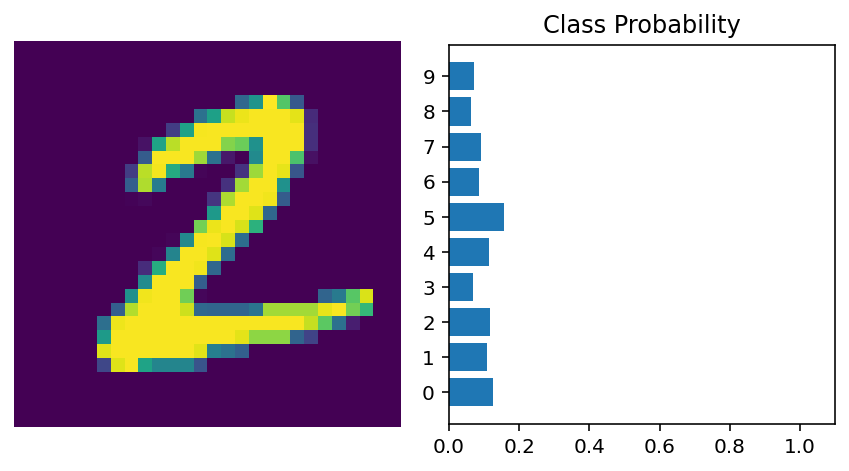

In [44]:
#Grab some data from out trainloader
dataiter = iter(trainloader)
images,labels = dataiter.next()

#resize the image to a 1D vector, new shape is (batch size, color channel, image pixels)
images.resize_(images.shape[0],1,784)

#do a forward pass through the nework
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1,28,28),ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

# Using `nn.sequential()`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [47]:
from collections import OrderedDict

#Hyperparameters for out network
input_size = 784
hidden_sizes = [128,64]
output_size = 64

#build a feed-forward network
model2 = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(input_size,hidden_sizes[0])),
    ('relu1',nn.ReLU()),
    ('fc2',nn.Linear(hidden_sizes[0], hidden_sizes[1])),
    ('relu2',nn.ReLU()),
    ('output',nn.Linear(hidden_sizes[1],output_size)),
    ('logsofmax',nn.LogSoftmax(dim = 1))
    
]))

print(model2)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=64, bias=True)
  (sofmax): Softmax(dim=1)
)


### Training
Here we are going to train the last network and use it to make predictions.

Using loss calculation, autograd and optimiser, we can complete the training process of our model for a numbe rof times called `empoch`.

Loss - is calculated using `cretrion`, which is `nn.NLLLoss()` in thise case since we are using `nn.LogSoftmax(dim = 1)` as out final output. Loss in neural network in simple the difference between predicted result and acual result. So to get this, we compare the actual label with the output from the neural network.

Autograd - is used to automatically calculate the gradient of tensors. Here we use to calculate the gradient of all our parameters with respect to the loss. Autograd works by keeping track of all the operations performed in tensors and going backward through those operations, calculating gradients along the way.To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

Optimser  - is used to update the weights with the gradients from autograd.

In [56]:
#criterion
criterion = nn.NLLLoss()

images,label  = next(iter(trainloader))
images = images.view(images.shape[0],-1)

##forward pass
logps = model2(images)
loss = criterion(logps,labels)

##backpropagation
loss.backward()

print(model2[0].weight.grad)


tensor([[ 2.9280e-04,  2.9280e-04,  2.9280e-04,  ...,  2.9280e-04,
          2.9280e-04,  2.9280e-04],
        [-9.8458e-06, -9.8458e-06, -9.8458e-06,  ..., -9.8458e-06,
         -9.8458e-06, -9.8458e-06],
        [ 4.1393e-04,  4.1393e-04,  4.1393e-04,  ...,  4.1393e-04,
          4.1393e-04,  4.1393e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.5405e-04,  5.5405e-04,  5.5405e-04,  ...,  5.5405e-04,
          5.5405e-04,  5.5405e-04],
        [ 5.2490e-06,  5.2490e-06,  5.2490e-06,  ...,  5.2490e-06,
          5.2490e-06,  5.2490e-06]])


In [69]:
##begint training
from torch import optim

#optimzers require the parameter to optimise and a learning rate
optimizer = optim.SGD(model2.parameters(),lr=0.01)

##print initial weight
print('Initial weight - ',model2.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(images.shape[0],784)

#clear the gradients, do this becuase gradients are accumulated
optimizer.zero_grad()

#forward pass, then backward pass, then update weight
output  = model(images)
loss = criterion(output,labels)
loss.backward()

#print weight after optimization
print('Gradient - ',model2.fc1.weight.grad)

Initial weight -  Parameter containing:
tensor([[-0.0215,  0.0284,  0.0020,  ..., -0.0032, -0.0245,  0.0026],
        [ 0.0240, -0.0160,  0.0334,  ...,  0.0079,  0.0167,  0.0287],
        [-0.0339,  0.0135,  0.0065,  ...,  0.0244,  0.0187, -0.0074],
        ...,
        [-0.0353,  0.0091, -0.0267,  ...,  0.0356, -0.0049, -0.0038],
        [-0.0010, -0.0101,  0.0107,  ..., -0.0004, -0.0018,  0.0245],
        [ 0.0076, -0.0048,  0.0197,  ...,  0.0259,  0.0145,  0.0143]],
       requires_grad=True)
Gradient -  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [70]:
#apply the optimiser
optimizer.step()

print('Updated Weight - ',model2.fc1.weight)

Updated Weight -  Parameter containing:
tensor([[-0.0215,  0.0284,  0.0020,  ..., -0.0032, -0.0245,  0.0026],
        [ 0.0240, -0.0160,  0.0334,  ...,  0.0079,  0.0167,  0.0287],
        [-0.0339,  0.0135,  0.0065,  ...,  0.0244,  0.0187, -0.0074],
        ...,
        [-0.0353,  0.0091, -0.0267,  ...,  0.0356, -0.0049, -0.0038],
        [-0.0010, -0.0101,  0.0107,  ..., -0.0004, -0.0018,  0.0245],
        [ 0.0076, -0.0048,  0.0197,  ...,  0.0259,  0.0145,  0.0143]],
       requires_grad=True)


## Real Training

Noww, lets put everything together and train out network for a number of times called epoch and then use it to make predictions.

In [72]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9380744402088337
Training loss: 0.8837437581723687
Training loss: 0.5343164585864366
Training loss: 0.43242045814421637
Training loss: 0.3863214784180686


With the network trained, we can chck out its predictions:

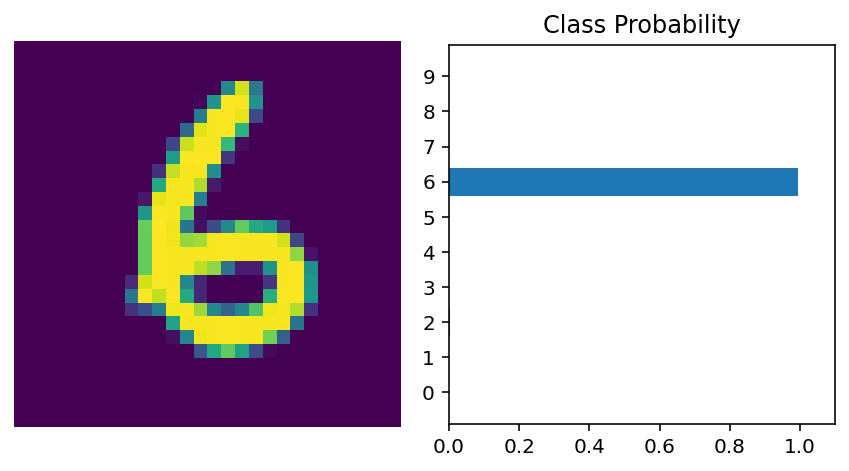

In [75]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)